<a href="https://colab.research.google.com/github/yej117/Cloud_Segmentation_Deep_Learning/blob/main/Copy_of_Image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
**Topic**: Image Segmentation <br>
**Details**: This project managed to finish the task of image segmentation on the Kaggle: [Carvana Image Masking Challenge](https://www.kaggle.com/c/carvana-image-masking-challenge/). The idea comes from the interests of knowing how to segment the object from the image. The datasets from the Carvana Image Masking Challenge based on high quality car photos and the backgrounds of the images usually ontain similar colors as cars. <br>
**Goals**: Work through the challenge and get to understand how image segmentation works, to know what are the state-or-art methods using for image segmentation, and to fine tune the image segmentation method with the knowledge we have learned from the course.

## Dataset
This project used the dataset from kaggle challenge: [Carvana Image Masking Challenge](https://www.kaggle.com/c/carvana-image-masking-challenge/). 
The dataset contains a large number of car images (as .jpg files). Each car has exactly 16 images, each one taken at different angles. 

The dataset provided by the challenge was separated into different folders and files as the following table (information from the kaggle challenge website)

> **Table 1**: Dataset information

|  file or folders | descriptions |
| -------------| ------------------ |
| train/ | the training dataset images |
| test/ | the test dataset images - the challenge is to predict the mask for each of the image inside |
| train_masks/ | the training set masks in *.gif format |
| train_masks.csv | run-length encoded version of the training set masks |
| sample_submission.csv | show the correct submission format |
| metadata.csv | basic information of about all the cars in the dataset. Note that some values are missing |

As there is no provided mask for the test dataset (which means that we cannot test the performance of our trained model), this project used the train dataset (`train/` and `train_masks/`) and splitted them into training, validation and test datasets.

# Load the dataset from Google Drive

 Mount your Google Drive to the kernel.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/DL_project/kaggle/data/

/content/drive/.shortcut-targets-by-id/1RpWol6vm8TFuJ9p0mkSUtbZHKsT3GtOy/DL_project/kaggle/data


Unzip the data in need.

In [ ]:
#!unzip train.zip
#!unzip train_masks.zip

# Data preprocessing

In [ ]:
import os

# Directory with our training car pictures
train_car_dir = os.path.join('/content/drive/MyDrive/DL_project/kaggle/data/train')

# Directory with our training mask pictures
train_mask_dir = os.path.join('/content/drive/MyDrive/DL_project/kaggle/data/train_masks')

In [ ]:
# read the filenames of train car and its mask, use "sorted" to have the same order
train_car_names = sorted(os.listdir(train_car_dir))
print(train_car_names[:10])

train_mask_names = sorted(os.listdir(train_mask_dir))
print(train_mask_names[:10])

['00087a6bd4dc_01.jpg', '00087a6bd4dc_02.jpg', '00087a6bd4dc_03.jpg', '00087a6bd4dc_04.jpg', '00087a6bd4dc_05.jpg', '00087a6bd4dc_06.jpg', '00087a6bd4dc_07.jpg', '00087a6bd4dc_08.jpg', '00087a6bd4dc_09.jpg', '00087a6bd4dc_10.jpg']
['00087a6bd4dc_01_mask.gif', '00087a6bd4dc_02_mask.gif', '00087a6bd4dc_03_mask.gif', '00087a6bd4dc_04_mask.gif', '00087a6bd4dc_05_mask.gif', '00087a6bd4dc_06_mask.gif', '00087a6bd4dc_07_mask.gif', '00087a6bd4dc_08_mask.gif', '00087a6bd4dc_09_mask.gif', '00087a6bd4dc_10_mask.gif']


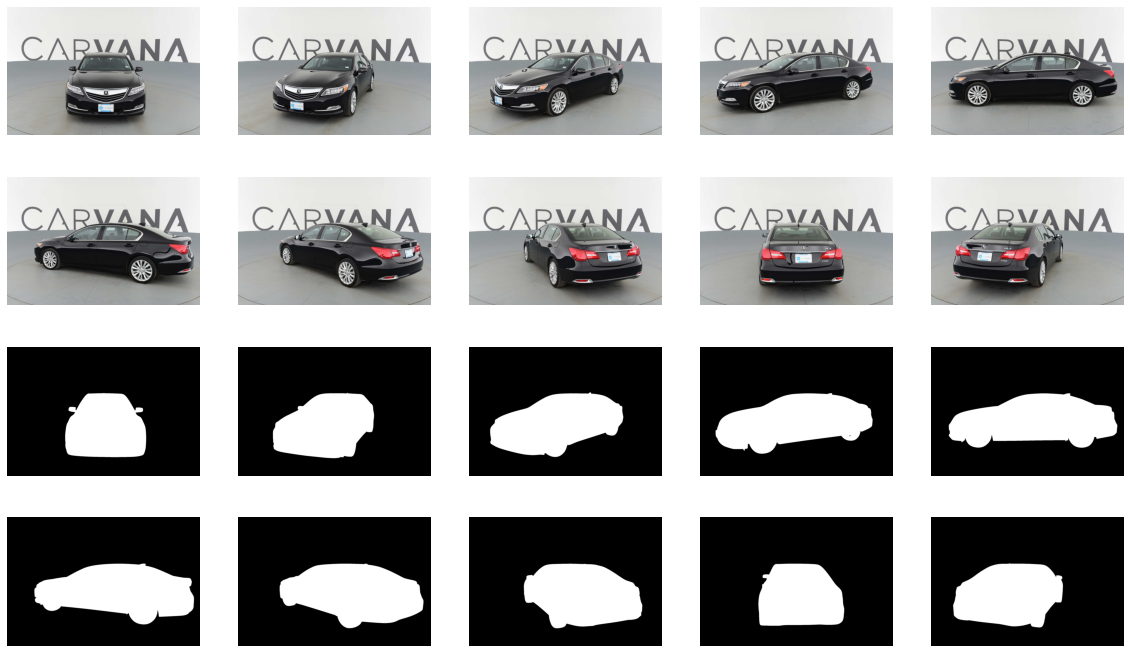

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 5

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 3)
pic_index = 0
#pic_index += 1
next_car_pix = [os.path.join(train_car_dir, fname) 
                for fname in train_car_names[pic_index:pic_index+10]]
next_mask_pix = [os.path.join(train_mask_dir, fname) 
                for fname in train_mask_names[pic_index:pic_index+10]]

preview_index = 10
for i, img_path in enumerate(next_car_pix+next_mask_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# Image Augmentation

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Load data to numpy array and resize it... (too powerful...)

In [ ]:
def load_data(car_list, mask_list, img_size):
  img_car = []
  img_mask = []
  # Load and resize the images
  for car, mask in zip(car_list, mask_list):
    img_car.append(cv2.resize(cv2.imread(car), (128,128)))
    img_mask.append(cv2.resize(plt.imread(mask), (128,128)))
    img = cv2.resize(cv2.imread(car), (128,128))

  # Split dataset into training (70%) and validation (30 %)                             
  x_train, x_val, y_train, y_val = train_test_split(img_car, img_mask,
                                                    test_size=0.3,
                                                    random_state=0)
  # Then split validation dataset into validation (20 %) and testing (10 %)
  x_val, x_test, y_val, y_test = train_test_split(x_val, y_val,
                                                  test_size=(1/3),
                                                  random_state=0)
  x_train = np.array(x_train)
  x_test = np.array(x_test)
  x_val = np.array(x_val)
    
  return x_train, x_val, x_test, y_train, y_val, y_test

In [ ]:
car_pix = [os.path.join(train_car_dir, fname) 
           for fname in train_car_names[:500]]
mask_pix = [os.path.join(train_mask_dir, fname) 
            for fname in train_mask_names[:500]]

x_train, x_val, x_test, y_train, y_val, y_test = load_data(car_pix, mask_pix, (128,128))

print("Training dataset: %i"%(len(x_train)))
print("Validation dataset: %i"%(len(x_val)))
print("Test dataset: %i"%(len(x_test)))

Training dataset: 350
Validation dataset: 100
Test dataset: 50


test

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

car_pix = [os.path.join(train_car_dir, fname) 
           for fname in train_car_names[:500]]
mask_pix = [os.path.join(train_mask_dir, fname) 
            for fname in train_mask_names[:500]]

img = cv2.resize(cv2.imread(car_pix[0]), (128,128))
mask = cv2.resize(plt.imread(mask_pix[0]), (128,128))

print(np.shape(mask))
print(np.shape(img))

(128, 128, 4)
(128, 128, 3)


Image Augmentation

In [ ]:
batch_size = 32
gen = ImageDataGenerator(
    rotation_range = 90,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    rescale=1./255,
    horizontal_flip = True,
    fill_mode = 'nearest')

gen_flow = gen.flow(x_train, y_train, batch_size = batch_size)



# Building model

https://www.kaggle.com/hackxxy/u-nets-with-keras

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Input, MaxPool2D, UpSampling2D, Concatenate, Conv2DTranspose
from keras.optimizers import Adam

In [ ]:
# First let's define the two different types of layers that we will be using.

def down(input_layer, filters, pool=True):
    conv1 = Conv2D(filters, (3, 3), padding='same', activation='relu')(input_layer)
    residual = Conv2D(filters, (3, 3), padding='same', activation='relu')(conv1)
    if pool:
        max_pool = MaxPool2D()(residual)
        return max_pool, residual
    else:
        return residual

def up(input_layer, residual, filters):
    filters=int(filters)
    upsample = UpSampling2D()(input_layer)
    upconv = Conv2D(filters, kernel_size=(2, 2), padding="same")(upsample)
    concat = Concatenate(axis=3)([residual, upconv])
    conv1 = Conv2D(filters, (3, 3), padding='same', activation='relu')(concat)
    conv2 = Conv2D(filters, (3, 3), padding='same', activation='relu')(conv1)
    return conv2

In [ ]:
# Now let's use Tensorflow to write our own dice_coeficcient metric
def dice_coef(y_true, y_pred):
    smooth = 1e-5
    
    y_true = tf.round(tf.reshape(y_true, [-1]))
    y_pred = tf.round(tf.reshape(y_pred, [-1]))
    
    isct = tf.reduce_sum(y_true * y_pred)
    
    return 2 * isct / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))

In [ ]:
def Unet():
  # Make a custom U-nets implementation.
  filters = 64
  input_layer = Input(shape = [128, 128, 3])
  layers = [input_layer]
  residuals = []

  # Down 1, 128
  d1, res1 = down(input_layer, filters)
  residuals.append(res1)
  filters *= 2

  # Down 2, 64
  d2, res2 = down(d1, filters)
  residuals.append(res2)
  filters *= 2

  # Down 3, 32
  d3, res3 = down(d2, filters)
  residuals.append(res3)
  filters *= 2

  # Down 4, 16
  d4, res4 = down(d3, filters)
  residuals.append(res4)
  filters *= 2

  # Down 5, 8
  d5 = down(d4, filters, pool=False)

  # Up 1, 16
  up1 = up(d5, residual=residuals[-1], filters=filters/2)

  filters /= 2

  # Up 2,  32
  up2 = up(up1, residual=residuals[-2], filters=filters/2)

  filters /= 2

  # Up 3, 64
  up3 = up(up2, residual=residuals[-3], filters=filters/2)

  filters /= 2

  # Up 4, 128
  up4 = up(up3, residual=residuals[-4], filters=filters/2)

  out = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(up4)

  model = Model(input_layer, out)

  
  model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=[dice_coef])
  return model

In [ ]:
model = Unet()
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_115 (Conv2D)             (None, 128, 128, 64) 1792        input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_116 (Conv2D)             (None, 128, 128, 64) 36928       conv2d_115[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_20 (MaxPooling2D) (None, 64, 64, 64)   0           conv2d_116[0][0]                 
____________________________________________________________________________________________

# TRAINING OUR MODEL

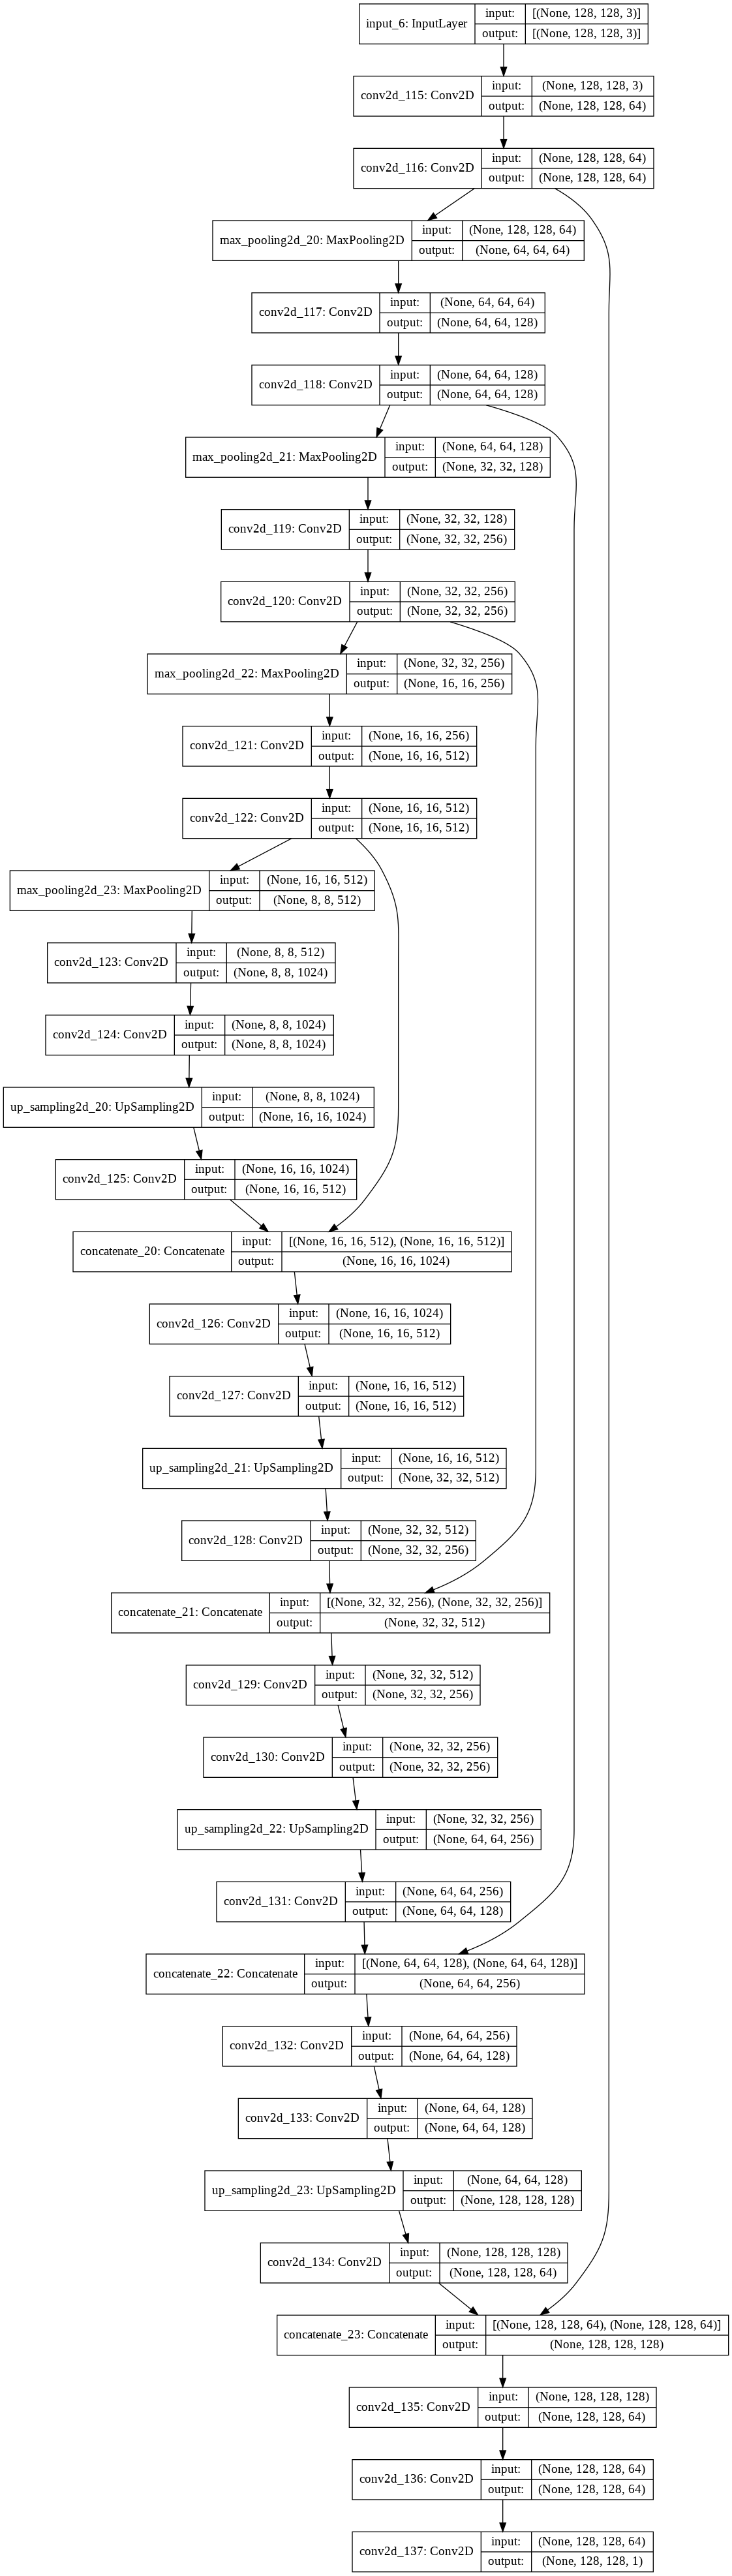

In [ ]:
#Visualise this architecture:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer = Adam(lr = 1e-4), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
history = model.fit_generator(gen_flow,
                    steps_per_epoch=10,
                    epochs=10,
                    validation_data = gen.flow(x_val, y_val, batch_size = batch_size))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
10/10 [==============================] - 3s 324ms/step - loss: nan - accuracy: 0.5951 - val_loss: nan - val_accuracy: 0.5863
Epoch 2/10
10/10 [==============================] - 3s 326ms/step - loss: nan - accuracy: 0.5933 - val_loss: nan - val_accuracy: 0.5863
Epoch 3/10
10/10 [==============================] - 3s 323ms/step - loss: nan - accuracy: 0.5948 - val_loss: nan - val_accuracy: 0.5863
Epoch 4/10
10/10 [==============================] - 3s 322ms/step - loss: nan - accuracy: 0.5943 - val_loss: nan - val_accuracy: 0.5863
Epoch 5/10
10/10 [==============================] - 3s 326ms/step - loss: nan - accuracy: 0.5945 - val_loss: nan - val_accuracy: 0.5863
Epoch 6/10
10/10 [==============================] - 3s 325ms/step - loss: nan - accuracy: 0.5950 - val_loss: nan - val_accuracy: 0.5863
Epoch 7/10
10/10 [==============================] - 3s 326ms/step - loss: nan - accuracy: 0.5942 - val_loss: nan - val_accuracy: 0.5863
Epoch 8/10
10/10 [==============================

In [ ]:
import tensorflow as tf

In [ ]:
def create_mask(predicted_mask):
  predicted_mask = tf.argmax(predicted_mask, axis=-1)
  predicted_mask= predicted_mask[..., tf.newaxis]
  return predicted_mask[0]

In [ ]:
def show_prediction(dataset, num ):
  if dataset:
    for image, mask in dataset.take(num):
      predicted_mask = model.predict(image)
      display([image[num], mask[num], create_mask(predicted_mask)])

In [ ]:
show_prediction(x_test.all(), 3)